# Step 5 Modeling

**Introduction**

IEEE Computational Intelligence Society (IEEE-CIS) works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with Vesta, the world’s leading payment service company, seeking the best solutions for the fraud detection industry. The fraud prevention system used by Vesta is actually saving consumers millions of dollars per year. Researchers from the IEEE-CIS want to improve fraud detection accuracy but also the customer experiences.

**Data Source**

The data comes from Vesta’s real-world e-commerce transactions and contains a wide range of features from device type to product features, available in Kaggle competition (https://www.kaggle.com/c/ieee-fraud-detection/data). Only train_identity and train_transaction datasets will be used for this project.

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
 
3.   Exploratory Data Analysis

4.   Pre-processing and Training Data Development

5.   **Modeling**
    - Logistic Regression
    - Decision Trees
    - Random Forest - Ensemble Method
    - Gradient Boosting/XGBoost

6.   Documentation

In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#os.getcwd()

In [2]:
path="/Users/huluhulu/Desktop/Capstone 2 Fraud Detection/data"
os.chdir(path) 

df = pd.read_csv('step3_output.csv')
test = pd.read_csv('test.csv')
test = test[['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'C3', 'D1', 'D4', 'D10', 'D15', 'M6', 'V25', 'V26', 'V46', 'V47', 'V55', 'V56', 'V61', 'V62', 'V66', 'V67', 'V77', 'V78', 'V82', 'V83', 'V98', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V114', 'V115', 'V116', 'V118', 'V120', 'V121', 'V122', 'V124', 'V281', 'V282', 'V283', 'V284', 'V286', 'V291', 'V297', 'V299', 'V305', 'V311']]

In [3]:
print(df.head())
print(test.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987001        0          86401            29.0         W   2755   
1        2987002        0          86469            59.0         W   4663   
2        2987003        0          86499            50.0         W  18132   
3        2987005        0          86510            49.0         W   5937   
4        2987006        0          86522           159.0         W  12308   

   card2  card3       card4  card5  ... V281  V282  V283 V284  V286  V291  \
0  404.0  150.0  mastercard  102.0  ...  0.0   1.0   1.0  0.0   0.0   1.0   
1  490.0  150.0        visa  166.0  ...  0.0   1.0   1.0  0.0   0.0   1.0   
2  567.0  150.0  mastercard  117.0  ...  0.0   0.0   0.0  0.0   0.0   1.0   
3  555.0  150.0        visa  226.0  ...  0.0   1.0   1.0  0.0   0.0   1.0   
4  360.0  150.0        visa  166.0  ...  0.0   1.0   1.0  0.0   0.0   1.0   

   V297  V299  V305 V311  
0   0.0   0.0   1.0  0.0  
1   0.0   0.0   1.0 

#### Some Feature Engineering
See Step 4

In [4]:
# Train
df['TransactionAmt_log'] = np.log(df['TransactionAmt'])
df['Transaction_day'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
    
# Card features encoding
for col in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']:
    freq = df[col].value_counts(dropna=False).to_dict()
    df[col+'_freq'] = df[col].map(freq)

 # email feature
df['P_emaildomain'] = df['P_emaildomain'].fillna('email_not_provided')
df['P_prefix'] = df['P_emaildomain'].apply(lambda x: x.split('.')[0])

    # objects
from sklearn.preprocessing import LabelEncoder
for col in df.drop('isFraud', axis=1).columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))
        
# V features - normalization
V = df[['V25', 'V26', 'V46', 'V47', 'V55', 'V56', 'V61', 'V62', 'V66', 'V67', 'V77', 'V78', 'V82', 'V83', 'V98', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V114', 'V115', 'V116', 'V118', 'V120', 'V121', 'V122', 'V124', 'V281', 'V282', 'V283', 'V284', 'V286', 'V291', 'V297', 'V299', 'V305', 'V311']]
for v in V:
    df[v] = (df[v] - df[v].mean()) / df[v].std()

# Fill NAs
for col in ['addr1', 'addr2', 'card2', 'card5', 'card3']:
    df[col].fillna(-1, inplace=True)


In [5]:
#Test
test['TransactionAmt_log'] = np.log(test['TransactionAmt'])
test['Transaction_day'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24
    
# Card features encoding
for col in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']:
    freq = test[col].value_counts(dropna=False).to_dict()
    test[col+'_freq'] = test[col].map(freq)

# email feature
test['P_emaildomain'] = test['P_emaildomain'].fillna('email_not_provided')
test['P_prefix'] = test['P_emaildomain'].apply(lambda x: x.split('.')[0])

# objects
for col in test.columns:
    if test[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(test[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))
        
# V features - normalization
V_test = test[['V25', 'V26', 'V46', 'V47', 'V55', 'V56', 'V61', 'V62', 'V66', 'V67', 'V77', 'V78', 'V82', 'V83', 'V98', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V114', 'V115', 'V116', 'V118', 'V120', 'V121', 'V122', 'V124', 'V281', 'V282', 'V283', 'V284', 'V286', 'V291', 'V297', 'V299', 'V305', 'V311']]
for v in V_test:
    test[v] = (test[v] - test[v].mean()) / test[v].std()

# Fill NAs
for col in test:
    test[col].fillna(-1, inplace=True)

In [6]:
df['isFraud'].dtype

dtype('int64')

In [8]:
df['isFraud'] = df['isFraud'].astype(float)

#### Split into Training, Validation, and Testing Sets

In [10]:
X = df.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = df.sort_values('TransactionDT')['isFraud']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.25, train_size =0.75, random_state=123)

#### Oversampling - SMOTE

In [12]:
import imblearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=123)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

### Model Evaluation
We will choose the best models based on macro-averaged f1 score
- **Recall** = TP/(TP+FN)
    - fraud correctly detected / (fraud correctly detected + transaction identified as nonfraud that is actually fraud)
    - as recall increases, precision decreases
- **Precision** = TP/(TP+FP)
    - fraud correctly detected / (fraud correctly detected + nonfraud transaction incorrectly idenfitied as fraud)
- **F1 score** = 2 * (recall * precision)/(recall + precision)
    - harmonic mean of recall and precision
- **Balanced Accuracy**: the average of recall obtained on each class, used instead of accuracy to deal with imbalanced datasets
- **Receiver Operating Characteristic (ROC)**:
    - plots TPR vs FPR as a function of model's threshold for classifying positive
    - TPR = TP/(TP+FN)
    - FPR = FP/(FP+TN)
- **Area Under the Curve (AUC)**:
    - metric to calculate overal performance based on the area under the ROC curve
- Averages
    - micro-averaged: all samples equally contributed to the average; weight towards the majority class
    - macro-averaged: all classes equally contributed; treats examples from minority classes as being more important than those from majority classes
    - weighted: each class' contribution to the average is weighted by its size

In [13]:
models = [] 
precision = []
recall = []
f1 = []
auc = []

### Logistic Regression

- a form of binary regression

In [14]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [15]:
lr1 = LogisticRegression()
lr1.fit(X_train_sm, y_train_sm)
y_pred1 = lr1.predict(X_test)

print("Logistic Regression, after oversampling")
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred1)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred1, average='macro')))
print("Recall score {:.4f}".format(f1_score(y_test, y_pred1, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred1, average='macro')))
print("AUC ROC score {:.4f}".format(roc_auc_score(y_test, y_pred1, average='macro')))

Logistic Regression, after oversampling
Balanced accuracy score: 0.6907
Precision score 0.5323
Recall score 0.5009
F1 score 0.5009
AUC ROC score 0.6907


Here we choose the macro parameter to emphasize the minority class (fraud transactions)

In [16]:
%%time
param_grid = {'C': [0.05, 0.1, 0.5, 1, 5, 10]}

clf1 = GridSearchCV(LogisticRegression(), param_grid, cv=5)
clf1.fit(X_train, y_train)

print("Best parameters set found on development set: {}".format(clf1.best_params_))

Best parameters set found on development set: {'C': 0.1}
CPU times: user 2min 34s, sys: 8.85 s, total: 2min 42s
Wall time: 1min 23s


In [17]:
lr2 = LogisticRegression(C = 0.05)
lr2.fit(X_train, y_train)
y_pred2 = lr2.predict(X_test)

In [18]:
print("Logistic Regression, no oversampling")
print('Validation Results')
print("Precision score {:.4f}".format(precision_score(y_cv, lr2.predict(x_cv), average='macro')))
print("Recall score {:.4f}".format(recall_score(y_cv, lr2.predict(x_cv), average='macro')))
print("F1 score {:.4f}".format(f1_score(y_cv, lr2.predict(x_cv), average='macro')))
print('\nTest Results')
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred2)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred2, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, y_pred2, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred2, average='macro')))
print("AUC ROC score {:.4f}".format(roc_auc_score(y_test, y_pred2, average='macro')))

Logistic Regression, no oversampling
Validation Results
Precision score 0.4834
Recall score 0.5000
F1 score 0.4916

Test Results
Balanced accuracy score: 0.5000
Precision score 0.4835
Recall score 0.5000
F1 score 0.4916
AUC ROC score 0.5000


In [19]:
models.append("Logistic Regression")
precision.append(precision_score(y_test, y_pred2, average='macro'))
recall.append(recall_score(y_test, y_pred2, average='macro'))
f1.append(f1_score(y_test, y_pred2, average='macro'))
auc.append(roc_auc_score(y_test, y_pred2, average='macro'))

### Decision tree
- Entropy model
    - It is a measure of uncertainty in which category the data-points fall into at a given point in the tree. In other words, given a probability distribution, the information required to predict the event is the distribution's entropy. 
    - Information gain of a specific feature with a threshold is the difference in entropy that exists before and after splitting on that feature.
    - We want to minimize entropy and maximize informational gain
    - Entropy outperforms gini if the proability distribution is exponential or Laplace
- Gini impurity model
    - Similar to entropy, a measure of how well the threshold splits the data. It's the expected error if randomly choose a sample and predict the class of the entire node based on it. The higher the gini impurity, the lower the error.
    - It takes slightly more computation time.

In [20]:
%%time
entro = tree.DecisionTreeClassifier(criterion="entropy", random_state = 123, max_depth = 10)
entro.fit(X_train, y_train)
y_pred3 = entro.predict(X_test)

CPU times: user 3.13 s, sys: 91.4 ms, total: 3.23 s
Wall time: 3.24 s


In [21]:
print("Decision Tree Entropy Model, Max Depth 10")
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred3)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred3, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, y_pred3, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred3, average='macro')))
print("ROC-AUC score {:.4f}".format(roc_auc_score(y_test, y_pred3, average='macro')))

Decision Tree Entropy Model, Max Depth 10
Balanced accuracy score: 0.6344
Precision score 0.8529
Recall score 0.6344
F1 score 0.6913
ROC-AUC score 0.6344


In [22]:
%%time
entro2 = tree.DecisionTreeClassifier(criterion="entropy", random_state = 123, max_depth = 8)
entro2.fit(X_train, y_train)
y_pred_3 = entro2.predict(X_test)
print("Decision Tree Entropy Model, Max Depth 8")
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred_3)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred_3, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, y_pred_3, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred_3, average='macro')))
print("ROC-AUC score {:.4f}".format(roc_auc_score(y_test, y_pred_3, average='macro')))

Decision Tree Entropy Model, Max Depth 8
Balanced accuracy score: 0.6131
Precision score 0.8571
Recall score 0.6131
F1 score 0.6676
ROC-AUC score 0.6131
CPU times: user 2.67 s, sys: 102 ms, total: 2.77 s
Wall time: 2.77 s


In [23]:
%%time
gini = tree.DecisionTreeClassifier(criterion="gini", random_state = 123, max_depth = 10)
gini.fit(X_train, y_train)
y_pred4 = gini.predict(X_test)

print("Decision Tree Gini Impurity Model, Max Depth 10")
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred4)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred4, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, y_pred4, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred4, average='macro')))
print("ROC-AUC score {:.4f}".format(roc_auc_score(y_test, y_pred4, average='macro')))

Decision Tree Gini Impurity Model, Max Depth 10
Balanced accuracy score: 0.6357
Precision score 0.8456
Recall score 0.6357
F1 score 0.6917
ROC-AUC score 0.6357
CPU times: user 3.17 s, sys: 82.5 ms, total: 3.25 s
Wall time: 3.25 s


In [24]:
%%time
gini = tree.DecisionTreeClassifier(criterion="gini", random_state = 123, max_depth = 8)
gini.fit(X_train, y_train)
y_pred_4 = gini.predict(X_test)

print("Decision Tree Gini Impurity Model, Max Depth 8")
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred_4)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred_4, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, y_pred_4, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred_4, average='macro')))
print("ROC-AUC score {:.4f}".format(roc_auc_score(y_test, y_pred_4, average='macro')))

Decision Tree Gini Impurity Model, Max Depth 8
Balanced accuracy score: 0.6072
Precision score 0.8666
Recall score 0.6072
F1 score 0.6614
ROC-AUC score 0.6072
CPU times: user 2.74 s, sys: 110 ms, total: 2.85 s
Wall time: 2.86 s


In [25]:
print("Decision Tree Entropy Model, Max Depth 10")
print('Validation Results')
print("Precision score {:.4f}".format(precision_score(y_cv, entro.predict(x_cv), average='macro')))
print("Recall score {:.4f}".format(recall_score(y_cv, entro.predict(x_cv), average='macro')))
print("F1 score {:.4f}".format(f1_score(y_cv, entro.predict(x_cv), average='macro')))
print('\nTest Results')
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred3)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred3, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, y_pred3, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred3, average='macro')))
print("ROC-AUC score {:.4f}".format(roc_auc_score(y_test, y_pred3, average='macro')))

Decision Tree Entropy Model, Max Depth 10
Validation Results
Precision score 0.8551
Recall score 0.6290
F1 score 0.6857

Test Results
Balanced accuracy score: 0.6344
Precision score 0.8529
Recall score 0.6344
F1 score 0.6913
ROC-AUC score 0.6344


In [26]:
models.append("Decision Tree Entropy, Max Depth 10")
precision.append(precision_score(y_test, y_pred3, average='macro'))
recall.append(recall_score(y_test, y_pred3, average='macro'))
f1.append(f1_score(y_test, y_pred3, average='macro'))
auc.append(roc_auc_score(y_test, y_pred3, average='macro'))

### RandomForest - Ensemble method

It builds upon the idea of bagging - bootstrap aggregating. Bagging samples with replacement from the dataset: from some number of trees and predetermined depth, it selects a random subset of the data (by convention roughly 2/3 with replacement) and trains a decision tree on the subset of features. It learns a classifier for each bootstrap sample and average the results of classifiers. 

Due to current infrustrature limitation, the tuning takes way too long. We're not expecting a huge jump

In [ ]:
##### Random Forest
#%%time
#param_grid = { 
#    'n_estimators': [200, 500],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [4,5,6,7,8],
#    'criterion' :['gini', 'entropy']
#}
#rfc=RandomForestClassifier(random_state=123)
#rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#rfc_cv.fit(X_train, y_train)
#print("Best Score:" + str(rfc_cv.best_score_))
#print("Best Parameters: " + str(rfc_cv.best_params_))
######

In [27]:
%%time
rfc = RandomForestClassifier(n_estimators=100, random_state = 123, n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred5 = rfc.predict(X_test)

CPU times: user 2min 41s, sys: 1.27 s, total: 2min 43s
Wall time: 45.6 s


In [28]:
print("Random Forest")
print('Validation Results')
print("Precision score {:.4f}".format(precision_score(y_cv, rfc.predict(x_cv), average='macro')))
print("Recall score {:.4f}".format(recall_score(y_cv, rfc.predict(x_cv), average='macro')))
print("F1 score {:.4f}".format(f1_score(y_cv, rfc.predict(x_cv), average='macro')))
print('\nTest Results')
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred5)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred5, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, y_pred5, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred5, average='macro')))
print("ROC-AUC score {:.4f}".format(roc_auc_score(y_test, y_pred4, average='macro')))

Random Forest
Validation Results
Precision score 0.9447
Recall score 0.6923
F1 score 0.7654

Test Results
Balanced accuracy score: 0.7020
Precision score 0.9403
Recall score 0.7020
F1 score 0.7742
ROC-AUC score 0.6357


In [29]:
models.append("Random Forest")
precision.append(precision_score(y_test, y_pred5, average='macro'))
recall.append(recall_score(y_test, y_pred5, average='macro'))
f1.append(f1_score(y_test, y_pred5, average='macro'))
auc.append(roc_auc_score(y_test, y_pred5, average='macro'))

### KNN

In [ ]:
#%%time
#test_scores = []
#train_scores = []

#for i in range(1,10):

#    knn = KNeighborsClassifier(i)
#    knn.fit(X_train,y_train)
#    knn.predict(X_test)
#    train_scores.append(knn.score(X_train,y_train))
#    test_scores.append(knn.score(X_test,y_test))

### Gradient Boosting and XGBoost

Graident Boosting learns from residual errors directly rather than update the weights of data points. Training is done iteratively, relies on results of the tree before it and places higher weights on data that got wrong previously. 
- Cons: harder to tune but easier to overfit (as it focus on those got wrong)
- Pros: more powerful and better performance

XGBoost (Extreme Gradient Boosting) is an implementation of gradient boosted decision trees, uses advanced regularization (L1&L2) to improve generalization capabilities and therefore reduce overfitting. It delivers higher speed and performance compared to Gradient Boosting and can be distributed across clusters. XGBoost allows users to not only define custom optimization objectives and evaluation criteria but also run a cross-validation at each iteration.

In [30]:
from xgboost import XGBClassifier
import xgboost as xgb

In [ ]:
# Parameter Tuning
#model = xgb.XGBClassifier()
#param = {"max_depth": [5,10,20,30,40,50],
#              "min_child_weight" : [1,3,5],
#              "n_estimators": [200],
#              "learning_rate": [0.05, 0.1, 0.15, 0.2],}
#grid_search = GridSearchCV(model, param_grid=param, cv = 5, n_jobs=-1)
#grid_search.fit(X_train, y_train)
#grid_search.best_estimator_

In [31]:
%%time
model1 = xgb.XGBClassifier(max_depth=50, min_child_weight=1, n_estimators=200, gamma=0,\
                           subsample=0.8, colsample_bytree=0.8, n_jobs=-1, learning_rate=0.05)
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)

CPU times: user 17min 41s, sys: 10.5 s, total: 17min 51s
Wall time: 18min 30s


In [32]:
print("XGBoost")
print('Validation Results')
print("Precision score {:.4f}".format(precision_score(y_cv, model1.predict(x_cv), average='macro')))
print("Recall score {:.4f}".format(recall_score(y_cv, model1.predict(x_cv), average='macro')))
print("F1 score {:.4f}".format(f1_score(y_cv, model1.predict(x_cv), average='macro')))
print('\nTest Results')
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, pred1)))
print("Precision score {:.4f}".format(precision_score(y_test, pred1, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, pred1, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, pred1, average='macro')))
print("ROC-AUC score {:.4f}".format(roc_auc_score(y_test, pred1, average='macro')))

XGBoost
Validation Results
Precision score 0.9555
Recall score 0.7262
F1 score 0.7999

Test Results
Balanced accuracy score: 0.7302
Precision score 0.9504
Recall score 0.7302
F1 score 0.8024
ROC-AUC score 0.7302


In [33]:
models.append("XGBoost")
precision.append(precision_score(y_test, pred1, average='macro'))
recall.append(recall_score(y_test, pred1, average='macro'))
f1.append(f1_score(y_test, pred1, average='macro'))
auc.append(roc_auc_score(y_test, pred1, average='macro'))

In [ ]:
%%time
model1.fit(X_train_sm, y_train_sm)
pred2 = model1.predict(X_test)

In [ ]:
print("XGBoost after oversampling")
print('Validation Results')
print("Precision score {:.4f}".format(precision_score(y_cv, model1.predict(x_cv), average='macro')))
print("Recall score {:.4f}".format(recall_score(y_cv, model1.predict(x_cv), average='macro')))
print("F1 score {:.4f}".format(f1_score(y_cv, model1.predict(x_cv), average='macro')))
print('\nTest Results')
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, pred2)))
print("Precision score {:.4f}".format(precision_score(y_test, pred2, average='macro')))
print("Recall score {:.4f}".format(recall_score(y_test, pred2, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, pred2, average='macro')))
print("ROC-AUC score {:.4f}".format(roc_auc_score(y_test, pred2, average='macro')))

### Model Comparisons and Selection

We will select the best fit based on f1 score

In [34]:
modelCompare = pd.DataFrame({'Model':[models[0], models[1], models[2], models[3]], 
                             'Precision': [precision[0], precision[1], precision[2], precision[3]],
                             'Recall': [recall[0], recall[1], recall[2], recall[3]],
                             'F1': [f1[0], f1[1], f1[2], f1[3]],
                             'AUC ROC': [auc[0], auc[1], auc[2], auc[3]] })
modelCompare

,Model,Precision,Recall,F1,AUC ROC
0,Logistic Regression,0.483481,0.500000,0.491602,0.500000
1,"Decision Tree Entropy, Max Depth 10",0.852852,0.634393,0.691286,0.634393
2,Random Forest,0.940277,0.702026,0.774226,0.702026
3,XGBoost,0.950389,0.730200,0.802431,0.730200


### Documentation

30


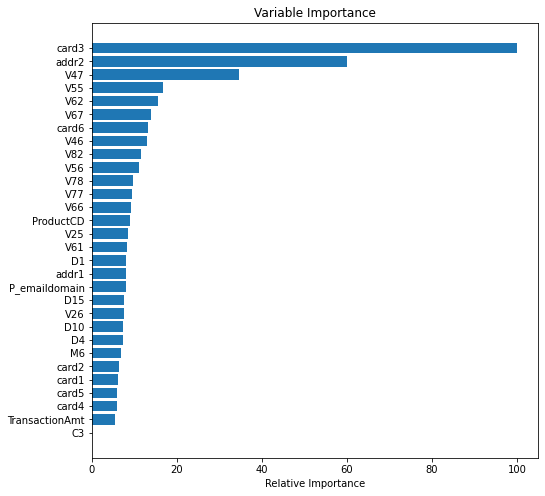

<Figure size 432x288 with 0 Axes>

In [39]:
feature_importance = model1.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
plt.savefig('figures/fig6.png',bbox_inches='tight')

In [36]:
# final prediction
test = test.sort_values('TransactionDT')
X_test2 = test.drop(['TransactionID', 'TransactionDT'], axis=1)
predict = model1.predict(X_test2)
test['isFraud'] = predict
rec = test[['TransactionID', 'isFraud']]
rec.head(30)

,TransactionID,isFraud
0,3663549,0.0
1,3663550,0.0
2,3663551,0.0
3,3663552,0.0
4,3663553,0.0
5,3663554,0.0
6,3663555,0.0
7,3663556,0.0
8,3663557,0.0
9,3663558,0.0


In [ ]:
#compare = pd.DataFrame({'predicted': pred1, 'actual': y_test, 'amount': X_test['TransactionAmt']})
#lost = compare.loc[(compare.predicted<0.5) & (compare.actual==1)]
#save = compare.loc[(compare.predicted>0.5) & (compare.actual==1)]
#flag = compare.loc[(compare.predicted>0.5) & (compare.actual==0)]
#normal = compare.loc[(compare.predicted<0.5) & (compare.actual==0)]
#print("Successfuly detection saved: ${:.2f}".format(np.sum(save.amount)))
#print("Failed detection cost: ${:.2f}".format(np.sum(lost.amount)))
#print("False alarm cost: ${:.2f}".format(np.sum(flag.amount)))
#print("Normal transaction: ${:.2f}".format(np.sum(normal.amount)))
#print("Total transaction: ${:.2f}".format(np.sum(compare.amount)))
#print("prediction length " + str(len(compare)) + ", fraud detection length " + str(len(save)) + ", failed " + str(len(lost)))